In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.stats import norm
import copy

Using dropout we get homoscedastic model uncertainty. This can be seen from the model definition [Gal and Ghahramani 2015, equation 8]. The likelihood in our derivations is defined as $y_i \sim N(\mu^W(x_i), \tau^{-1} I)$ with $\mu^W$ the network output, dependent on the randomly dropped weights $W$. Here our model precision $\tau$ (which is the same as the inverse observation noise) is a constant, which has to be tuned for the data.

We can easily adapt the model to obtain data-dependent noise. This simply involves making $\tau$ into a function of the data, very much like $\mu^W$ being a function of the data. We can tie the two functions together, splitting the top layer of a network between predictive mean $\mu(x)$ and predictive variance $\tau^{-1}(x)$ (of course we would want to re-parametrise this to make sure $\tau$ is positive). Thus the new (now heteroscedastic!) model likelihood is given by $y_i \sim N(\mu^W(x_i), \tau^{-1,W}(x_i) I)$.

In [2]:
def get_sample(size=10):
    X = np.linspace(-2, 2, size)
    epsilon = np.sin(X) + np.random.normal(0, 0.25, size=size)
    y = X + epsilon
    return torch.from_numpy(X[:, None]).float(), torch.from_numpy(y[:, None]).float()

In [3]:
class Regression(nn.Module):
    def __init__(self, in_features=1, bias=True, dropout=0., aleatoric=False):
        super(Regression, self).__init__()
        self.aleatoric = aleatoric
        self.linear = nn.Sequential(
            nn.Linear(in_features, 2, bias=bias),
            nn.Dropout(dropout)
        )
        self.mu = nn.Linear(2, 1, bias=bias)
        if aleatoric:
            self.log_var = nn.Linear(2, 1, bias=bias)
        
    def forward(self, x):
        x = self.linear(x)
        if self.aleatoric:
            return self.mu(x), self.log_var(x)
        else:
            return self.mu(x)

In [4]:
def aleatoric_loss(true, pred, var):
    """
    Taken from https://arxiv.org/pdf/1703.04977.pdf
    Theory says we should implement equation (5),
    but practice says equation (8).
    This paper is for computer vision, but the theory behind it applies to
    Params
    ======
    true: torch tensor
        The true targets
    pred: torch tensor
        The predictions
    var: torch tensor
        The uncertainty of every prediction (actually log(var)).
    """
    loss = torch.exp(-var) * (true - pred)**2 / 2
    loss += 0.5 * var
    return torch.mean(loss)

In [5]:
def train(X, y, X_test, y_test, aleatoric=False, dropout=0.0):

    net = Regression(in_features=X.shape[1], dropout=dropout, aleatoric=aleatoric)

    optim = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.0001)
    criterion = nn.MSELoss()
    diff = 1
    pbar = tqdm.tqdm()
    i = 0
    patience = 0
    best_loss = np.inf
    losses = []
    best_net = copy.deepcopy(net)
    while True:
        net.train(True)
        optim.zero_grad()
        
        if aleatoric:
            pred, var = net(X)
            pbar_str = "Loss aleatoric {:.4f}"
            loss = aleatoric_loss(y, pred, var)
            
        else:
            pred = net(X)
            pbar_str = "Loss {:.4f}"
            loss = criterion(pred, y)
            

        losses.append(loss.item())
        pbar.update(1)
        if i % 10000 == 0:
            pbar.set_description(pbar_str.format(loss.item()))
            
        loss.backward()
        optim.step()
        
        net.eval()
        if aleatoric:
            pred_test, var_test = net(X_test)
            val_loss = aleatoric_loss(y_test, pred_test, var_test).item()
        else:
            pred_test = net(X_test)
            val_loss = criterion(pred_test, y_test).item()
            
        if val_loss < best_loss:
            if best_loss - val_loss < 0.0001:
                patience += 1
            else:
                patience = 0
                best_loss = val_loss
                best_net = copy.deepcopy(net)

        if patience >= 10 or i >= 150000:
            break
        i += 1
    pbar.set_description(pbar_str.format(loss))
    pbar.close()
    best_net(X_test)
    
    if aleatoric:
        pred_test, var_test = best_net(X_test)
    else:
        pred_test = best_net(X_test)
    
    MSE = ((pred_test - y_test)**2).mean()
    
    return net, MSE, losses
    
def monte_carlo(net, xlim=(-5, 5), T=100):
    x = np.linspace(xlim[0], xlim[1], 100)
    x_in = torch.from_numpy(x[:, None]).float()

    net.train(True)
    preds = np.empty((T, 100))
    for i in range(T):
        if net.aleatoric:
            pred, _ = net(x_in)
        else:
            pred = net(x_in)
        pred = pred.detach().numpy().squeeze()
        preds[i] = pred

    return preds, x

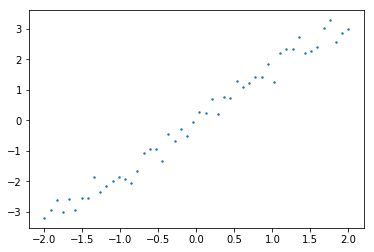

In [6]:
X, y = get_sample(50)
X_test, y_test = get_sample(50)
plt.scatter(X.numpy().squeeze(), y.numpy().squeeze(), s=2)
# plt.legend(['Train', 'Test'])
plt.savefig('antithetical.png')

In [7]:
lr_aleatoric, MSE_aleatoric, _ = train(X, y, X_test, y_test, dropout=0.1, aleatoric=True)
lr, MSE, _ = train(X, y, X_test, y_test, dropout=0.1, aleatoric=False)

Loss aleatoric -0.4984: : 150001it [01:09, 2161.40it/s]
Loss 0.3435: : 150001it [00:45, 3293.53it/s]


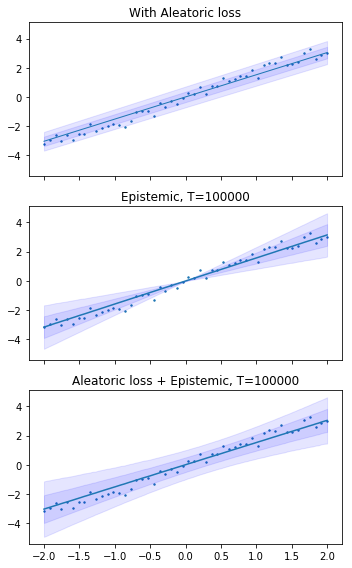

In [13]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=True, figsize=(5,8))
ax[0].scatter(np.squeeze(X[:,0]), np.squeeze(y), s=2)

# Plot aleatoric
x = np.linspace(-2, 2, 100)
lr_aleatoric.eval()
pred, log_var = lr_aleatoric(torch.from_numpy(x[:, None]).float())
pred = pred.detach().numpy().squeeze()
std = np.sqrt(np.exp(log_var.detach().numpy().squeeze()))
ax[0].plot(x, pred, lw=1)
ax[0].fill_between(x, pred - std, pred + std, alpha=0.1, color='b')
ax[0].fill_between(x, pred - 2*std, pred + 2*std, alpha=0.1, color='b')
ax[0].set_title('With Aleatoric loss')

# Plot Epistemic
T = 100000
preds, x = monte_carlo(lr, xlim=(-2, 2), T=T)
mean_preds = preds.mean(axis=0)
ax[1].scatter(np.squeeze(X[:,0]), np.squeeze(y), s=2)
ax[1].plot(x, mean_preds)
std = np.sqrt(preds.var(axis=0))
ax[1].fill_between(x, mean_preds-std, mean_preds+std, alpha=0.10, color='b')
ax[1].fill_between(x, mean_preds-2*std, mean_preds+2*std, alpha=0.10, color='b')
ax[1].set_title(f'Epistemic, T={T}')
    
# Plot Epistemic
preds, x = monte_carlo(lr_aleatoric, xlim=(-2, 2), T=T)
mean_preds = preds.mean(axis=0)
ax[2].scatter(np.squeeze(X[:,0]), np.squeeze(y), s=2)
ax[2].plot(x, mean_preds)
std = np.sqrt(preds.var(axis=0))
ax[2].fill_between(x, mean_preds-std, mean_preds+std, alpha=0.10, color='b')
ax[2].fill_between(x, mean_preds-2*std, mean_preds+2*std, alpha=0.10, color='b')
ax[2].set_title(f'Aleatoric loss + Epistemic, T={T}')

plt.tight_layout()
fig.savefig('toy_example_aleatoric_epistemic.png')